### 500225305 - Divya Hanspal
### Model-3 VAE(Variable Auto Encoder)

In [12]:
### Importing Libraries
import os
import gc
import cv2
import time
import lime
import psutil
import lime
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import lime.lime_image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import resample
from tensorflow.keras import layers, Model
import lime.lime_image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
warnings.filterwarnings("ignore", category=UserWarning)
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

Number of training samples: 12362
Number of test samples: 3091


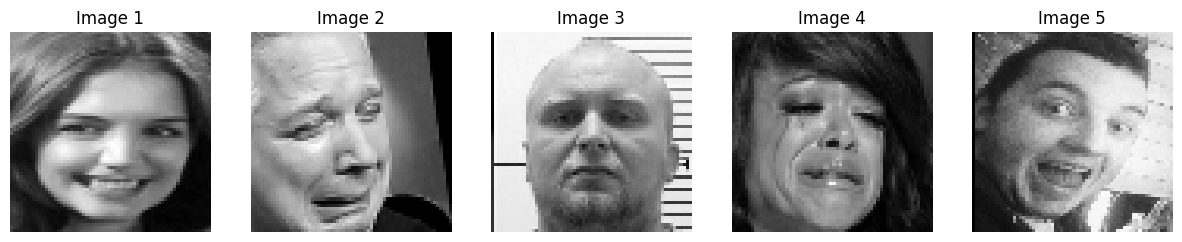

In [13]:
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

data_dir = '/kaggle/input/faceex/dataset'
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
IMG_SIZE = 64  # Increase the image size to reduce blurriness
batch_size = 32

# Function to preprocess images
def preprocess_image(file_path, label, augment=False):
    # Read and decode image
    img_raw = tf.io.read_file(file_path)
    img_decoded = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
    
    # Resize image
    img_resized = tf.image.resize(img_decoded, [IMG_SIZE, IMG_SIZE])
    
    if augment:
        # Data augmentation
        img_resized = tf.image.random_flip_left_right(img_resized)
        img_resized = tf.image.random_brightness(img_resized, max_delta=0.2)
        img_resized = tf.image.random_contrast(img_resized, lower=0.8, upper=1.2)
    
    # Convert to grayscale
    img_gray = tf.image.rgb_to_grayscale(img_resized)
    
    # Normalize image
    img_normalized = tf.cast(img_gray, tf.float32) / 255.0
    
    return img_normalized, label

# Loading image paths and their corresponding labels
def load_images_and_labels(data_dir, categories):
    paths = []
    labels = []
    for label, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        category_files = tf.io.gfile.listdir(category_dir)
        paths.extend([os.path.join(category_dir, file) for file in category_files])
        labels.extend([label] * len(category_files))
    return paths, labels

paths, labels = load_images_and_labels(data_dir, categories)

# Encoding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Splitting data
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, encoded_labels, test_size=0.2, stratify=encoded_labels)

# Printing the number of training and test samples
print(f'Number of training samples: {len(train_paths)}')
print(f'Number of test samples: {len(test_paths)}')

# Creating TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Apply preprocessing and batching
train_data = train_data.map(lambda x, y: preprocess_image(x, y, augment=True)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(lambda x, y: preprocess_image(x, y, augment=False)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to visualize preprocessed images
def visualize_preprocessed_images(dataset, num_images=5):
    # Get a batch from the dataset
    for images, _ in dataset.take(1):
        images = images.numpy()
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Image {i+1}")
            plt.axis("off")
        plt.show()

# Visualize preprocessed training images
visualize_preprocessed_images(train_data, num_images=5)


Encoder Summary:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_294 (Conv2D) │ (None, 64, 64,    │        320 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 32, 32,    │          0 │ conv2d_294[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_295 (Conv2D) │ (None, 32, 32,    │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 16, 16,    │          0 │ conv2d_295[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 16384)     │          0 │ max_pooling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │  2,097,280 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │      2,064 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 16)        │      2,064 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,120,224 (8.09 MB)

 Trainable params: 2,120,224 (8.09 MB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16384)          │       278,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,209 (1.27 MB)

 Trainable params: 334,209 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
387/387 ━━━━━━━━━━━━━━━━━━━━ 70s 181ms/step - kl_loss: 2.4362e-05 - loss: 0.6897 - reconstruction_loss: 0.6897 - val_loss: 0.0000e+00
Epoch 2/2
387/387 ━━━━━━━━━━━━━━━━━━━━ 81s 208ms/step - kl_loss: 0.0027 - loss: 0.6700 - reconstruction_loss: 0.6673 - val_loss: 0.0000e+00
Models saved successfully.
Complete VAE model saved successfully.


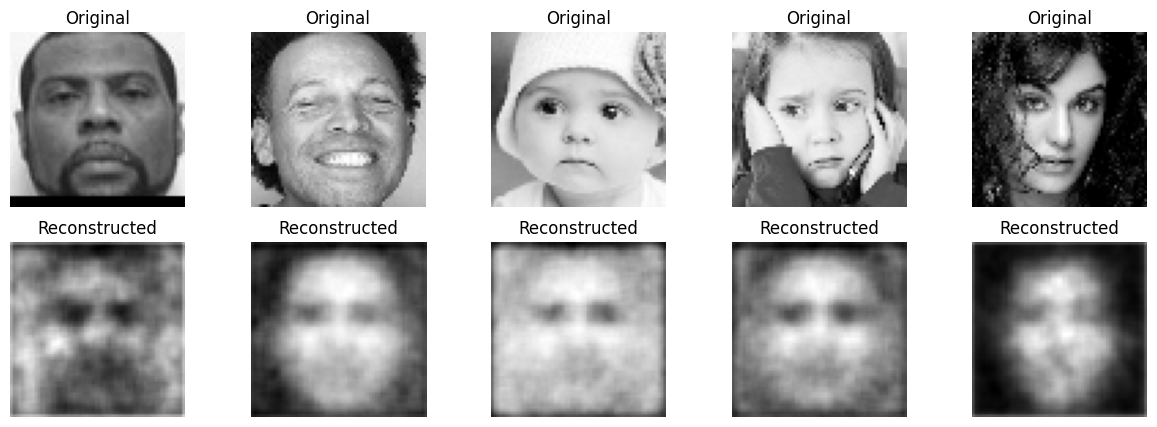

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# Mixed precision policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float16)
        z_mean, z_log_var = self.encoder(inputs)
        z = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(shape=tf.shape(z_mean), dtype=tf.float16)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def train_step(self, data):
        images, _ = data
        images = tf.cast(images, tf.float16)
        with tf.GradientTape() as tape:
            reconstruction, z_mean, z_log_var = self(images)
            flat_data = tf.reshape(images, [tf.shape(images)[0], -1])
            flat_reconstruction = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(flat_data, flat_reconstruction))
            IMG_SIZE = images.shape[1]
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)) / (IMG_SIZE * IMG_SIZE)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {'loss': total_loss, 'reconstruction_loss': reconstruction_loss, 'kl_loss': kl_loss}

def build_encoder(): # Building encoder
    encoder_input = layers.Input(shape=(64, 64, 1))  # Adjusted to match IMG_SIZE
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(16)(x)
    z_log_var = layers.Dense(16)(x)
    encoder = Model(encoder_input, [z_mean, z_log_var])
    return encoder

def build_decoder(): # Building decoder
    decoder_input = layers.Input(shape=(16,))
    x = layers.Dense(16*16*64, activation='relu')(decoder_input)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = Model(decoder_input, x)
    return decoder

encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7), loss=lambda y_true, y_pred: 0)

print("Encoder Summary:")
encoder.summary()
print("\nDecoder Summary:")
decoder.summary()

# Training the VAE model
epochs = 2  # Specify the number of epochs
vae.fit(train_data, epochs=epochs, validation_data=test_data)

# Saving the encoder and decoder.
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')
print("Models saved successfully.")

# Saving the complete VAE model
vae.save('vae_complete_model.h5')
print("Complete VAE model saved successfully.")

# Function to visualize original and reconstructed images
def visualize_reconstructed_images(model, dataset, num_images=5):
    for images, _ in dataset.take(1):
        reconstructed, _, _ = model(images)
        reconstructed = tf.cast(reconstructed, tf.float32)  # Convert to float32 for visualization
        images = tf.cast(images, tf.float32)
        
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Display original images
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title("Original")
            plt.axis("off")
            
            # Display reconstructed images
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
            plt.title("Reconstructed")
            plt.axis("off")
        plt.show()

# Visualize original and reconstructed images
visualize_reconstructed_images(vae, test_data, num_images=5)


In [8]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from scipy.linalg import sqrtm
import tensorflow as tf

# Initialize Inception V3 model for feature extraction
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Function to preprocess images for InceptionV3
def preprocess_images_for_inception(images):
    images_resized = np.array([resize(image, (299, 299), preserve_range=True, anti_aliasing=True) for image in images])
    if images_resized.ndim == 4 and images_resized.shape[-1] == 1:
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Converting grayscale to RGB
    return preprocess_input(images_resized)

# Function to generate images using VAE model
def generate_images(model, dataset, num_samples=100):
    generated_images = []
    for images, _ in dataset.take(1):
        reconstructed, _, _ = model(images)
        reconstructed = tf.cast(reconstructed, tf.float32)
        generated_images.append(reconstructed.numpy())
    generated_images = np.concatenate(generated_images, axis=0)
    return generated_images[:num_samples]

# Function to calculate FID
def calculate_fid(real_images, generated_images, model):
    if real_images.size == 0 or generated_images.size == 0:
        print("Error: One of the image batches is empty.")
        return float('nan')

    print(f"Real images shape: {real_images.shape}")
    print(f"Generated images shape: {generated_images.shape}")

    # Extract features from the Inception V3 model
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # Compute the mean and covariance of the features
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Calculate the sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in the result
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Generate images using the VAE model
all_generated_faces = generate_images(vae, test_data, num_samples=100)

# Load and preprocess real images
real_images = []
for images, _ in test_data.take(1):
    real_images.append(images.numpy())
real_images = np.concatenate(real_images, axis=0)

# Preprocess the images for InceptionV3
real_images_preprocessed = preprocess_images_for_inception(real_images)
generated_images_preprocessed = preprocess_images_for_inception(all_generated_faces)

# Calculate FID
if real_images_preprocessed.size > 0 and generated_images_preprocessed.size > 0:
    fid_score = calculate_fid(real_images_preprocessed, generated_images_preprocessed, inception_model)
    print("FID Score:", fid_score)
else:
    print("One or both image sets are empty.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Real images shape: (32, 299, 299, 3)
Generated images shape: (32, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
FID Score: 1.1747928697565005e+97


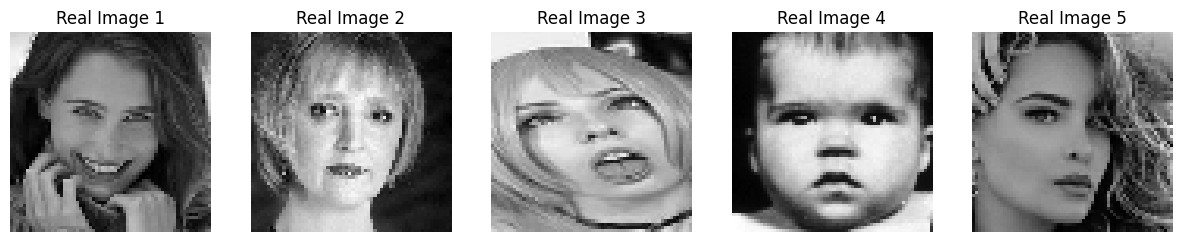

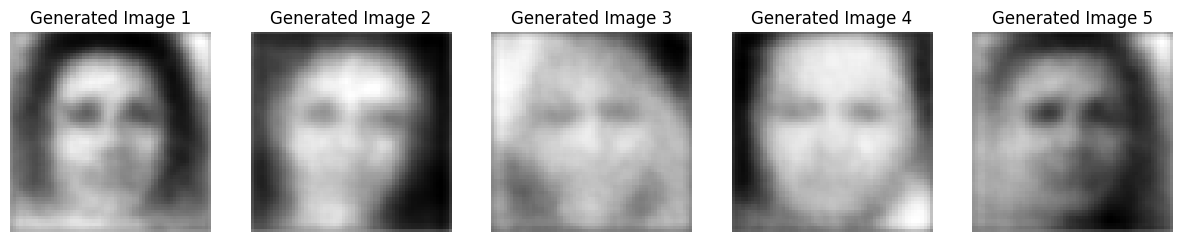

Real images shape: (32, 299, 299, 3)
Generated images shape: (32, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
FID Score: 6.681478002377114e+92


In [9]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import tensorflow as tf

# Initialize Inception V3 model for feature extraction
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Function to preprocess images for InceptionV3
def preprocess_images_for_inception(images):
    images_resized = np.array([resize(image, (299, 299), preserve_range=True, anti_aliasing=True) for image in images])
    if images_resized.ndim == 4 and images_resized.shape[-1] == 1:
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Converting grayscale to RGB
    return preprocess_input(images_resized)

# Function to generate images using VAE model
def generate_images(model, dataset, num_samples=100):
    generated_images = []
    for images, _ in dataset.take(1):
        reconstructed, _, _ = model(images)
        reconstructed = tf.cast(reconstructed, tf.float32)
        generated_images.append(reconstructed.numpy())
    generated_images = np.concatenate(generated_images, axis=0)
    return generated_images[:num_samples]

# Function to calculate FID
def calculate_fid(real_images, generated_images, model):
    if real_images.size == 0 or generated_images.size == 0:
        print("Error: One of the image batches is empty.")
        return float('nan')

    print(f"Real images shape: {real_images.shape}")
    print(f"Generated images shape: {generated_images.shape}")

    # Extract features from the Inception V3 model
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # Compute the mean and covariance of the features
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Calculate the sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in the result
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Function to plot images
def plot_images(images, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{title} {i + 1}")
        plt.axis("off")
    plt.show()

# Generate images using the VAE model
all_generated_faces = generate_images(vae, test_data, num_samples=100)

# Load and preprocess real images
real_images = []
for images, _ in test_data.take(1):
    real_images.append(images.numpy())
real_images = np.concatenate(real_images, axis=0)

# Plot real and generated images
plot_images(real_images, "Real Image")
plot_images(all_generated_faces, "Generated Image")

# Preprocess the images for InceptionV3
real_images_preprocessed = preprocess_images_for_inception(real_images)
generated_images_preprocessed = preprocess_images_for_inception(all_generated_faces)

# Calculate FID
if real_images_preprocessed.size > 0 and generated_images_preprocessed.size > 0:
    fid_score = calculate_fid(real_images_preprocessed, generated_images_preprocessed, inception_model)
    print("FID Score:", fid_score)
else:
    print("One or both image sets are empty.")


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Inception Score (Mean ± STD): 1.0 0.0


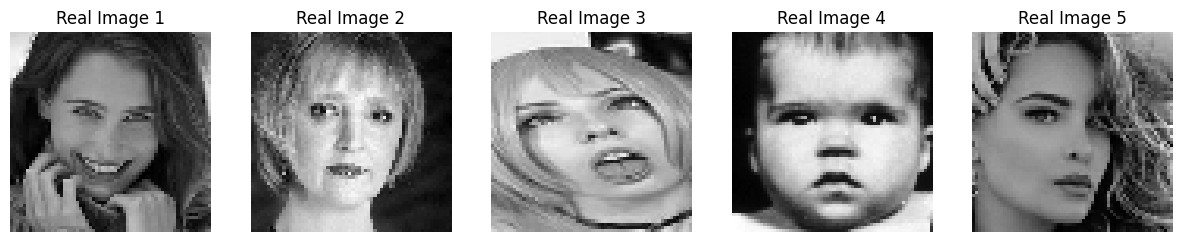

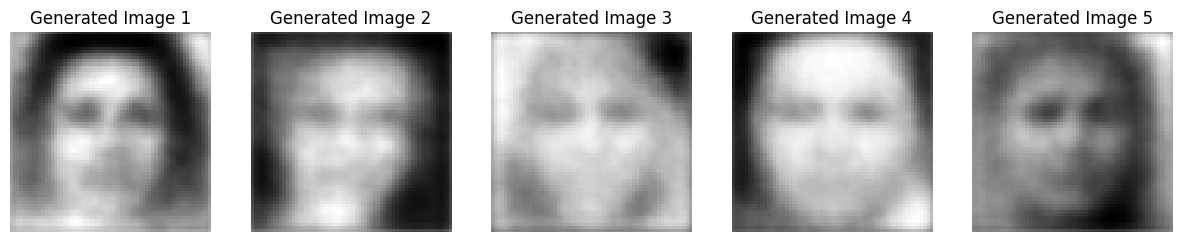

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt

# Load pre-trained InceptionV3 model for image classification
inception_model = InceptionV3(include_top=True, weights='imagenet')

# Function to preprocess images for InceptionV3
def preprocess_for_inception(images):
    images = tf.image.resize(images, (299, 299))
    images = tf.image.grayscale_to_rgb(images)  # Convert grayscale to RGB
    images = preprocess_input(images)
    return images

# Function to generate images using VAE model
def generate_images(model, dataset, num_images=100):
    generated_images = []
    for images, _ in dataset.take(1):
        reconstructed, _, _ = model(images)
        reconstructed = tf.cast(reconstructed, tf.float32)
        generated_images.append(reconstructed.numpy())
    generated_images = np.concatenate(generated_images, axis=0)
    return generated_images[:num_images]

# Function to calculate Inception Score
def calculate_inception_score(images, model, n_splits=10, eps=1e-4):
    images = preprocess_for_inception(images)
    preds = model.predict(images)
    preds = np.clip(preds, eps, 1.0)
    scores = []

    for i in range(n_splits):
        part = preds[i * len(preds) // n_splits: (i + 1) * len(preds) // n_splits]
        part_mean = np.mean(part, axis=0)
        kl_div = part * (np.log(part) - np.log(part_mean))
        kl_score = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_score))

    return np.mean(scores), np.std(scores)

# Generate images using the VAE model
all_generated_faces = generate_images(vae, test_data)

# Compute the Inception Score for generated images
inception_score, inception_std = calculate_inception_score(all_generated_faces, inception_model)
print("Inception Score (Mean ± STD):", inception_score, inception_std)

# Function to plot images
def plot_images(images, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{title} {i + 1}")
        plt.axis("off")
    plt.show()

# Plot real and generated images
real_images = []
for images, _ in test_data.take(1):
    real_images.append(images.numpy())
real_images = np.concatenate(real_images, axis=0)

plot_images(real_images, "Real Image")
plot_images(all_generated_faces, "Generated Image")
